<img src="images/MapleStory.SVG" align="right" width=30%>
# VAE for MapleStory Character Generation
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Data collection](#Data-collection)
- [Dataset](#Dataset)
- [Model](#Model)
- [Training](#Training)
    - [Single-batch test](#Single-batch-test)
    - [Coffee break](#Coffee-break)

In this notebook, we're going to build a **variational autoencoder** (VAE) model for generating [MapleStory](http://maplestory.nexon.net/landing/) characters. There wasn't any particular reason for the choice of data (I did collect the dataset myself, thinking it would be cool to be able to generate MapleStory characters), but the main goal of this project is to learn how VAE works as a generative model.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils import data
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
from torchsummary import summary
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [2]:
%matplotlib notebook

## Data collection

I won't share the images that I collected, as they are not mine, but I seemed to have accidentally left the script below that scrapes the same webpages. How careless of me.

In [ ]:
# NOTE: do NOT run this script unless it's necessary!

import time
from datetime import datetime
import pathlib
from uuid import uuid4
from urllib.request import Request, urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

try:
    # mkdir datasets/maple-vae if it doesn't exist yet
    pathlib.Path("datasets/maplestory").mkdir(parents=True)
except FileExistsError:
    print("datasets/maplestory already exists, moving on...")

# URL template for scraping MapleStory avatars from the ranking page
url_tmpl = ("http://maplestory.nexon.net/rankings/overall-ranking/"
            "legendary?rebootIndex=0&pageIndex={}#ranking")
for page_index in tqdm(range(1, 50000, 5)):
    url = url_tmpl.format(page_index)
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"}) # pretend you're human!
    soup = BeautifulSoup(urlopen(req), "html.parser")
    for av in soup.find_all("img", {"class": "avatar"}):
        for i in range(5): # try 5 times
            img_req = Request(av["src"], headers={"User-Agent": "Mozilla/5.0"})
            try:
                img = urlopen(img_req).read()
                with open(f"datasets/maplestory/{uuid4().hex}.png", "wb") as f:
                    f.write(img)
                break
            except ConnectionError:
                now = datetime.now()
                print(f"[{now}] Connection error, retrying in 3 seconds...", flush=True)
                time.sleep(3)
            except HTTPError:
                now = datetime.now()
                print(f"[{now}] HTTP error, skipping...", flush=True)
                break
        else:
            raise
    if page_index % 500 == 0:
        time.sleep(5)

Now, let's separate the dataset into a train set and a test set! Note that each file name is assigned randomly, and we will iterate through them in order of their names. I think it's safe to assume that there is no bias in how we separate the test set from the train set.

In [ ]:
%%bash

mkdir -p datasets/maplestory/train
mkdir -p datasets/maplestory/test

i=0
for f in datasets/maplestory/*.png; do
    if (($i < 40000)); then
        mv $f datasets/maplestory/train/
    else
        mv $f datasets/maplestory/test/
    fi
    i=$((i + 1))
done

ls datasets/maplestory/train | wc -l
ls datasets/maplestory/test | wc -l

## Configuration

In [3]:
# data image width
WIDTH = 128
# data image height
HEIGHT = 128
# number of epochs of training
N_EPOCHS = 10
# batch size for training
BATCH_SIZE = 16
# number of CPUs for batch sampling
N_CPU = 4
# latent variable size
Z_DIM = 500

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## Dataset

In [5]:
class MapleDataset(data.Dataset):
    def __init__(self, root, transform, mode="train"):
        self.transform = transform
        self._images = sorted(glob(f"{root}/{mode}/*.png"))
        
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, index):
        img = Image.open(self._images[index])
        pix = np.array(img)
        alpha = pix[:, :, 3] # alpha channel
        pix[alpha == 0.0] = 255 # whiten the transparent parts
        img = Image.fromarray(pix[:, :, :3], "RGB")
        return self.transform(img)

In [6]:
def get_loaders(root, transform, batch_size, num_workers=2):
    train_set = MapleDataset(root, transform=transform, mode="train")
    test_set = MapleDataset(root, transform=transform, mode="test")
    
    train_loader = data.DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=num_workers)
    test_loader = data.DataLoader(test_set,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers)
    return train_loader, test_loader

Let's take a look at some samples!

In [7]:
def imshow(img, title, figsize=(12, 12)):
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

<IPython.core.display.Javascript object>


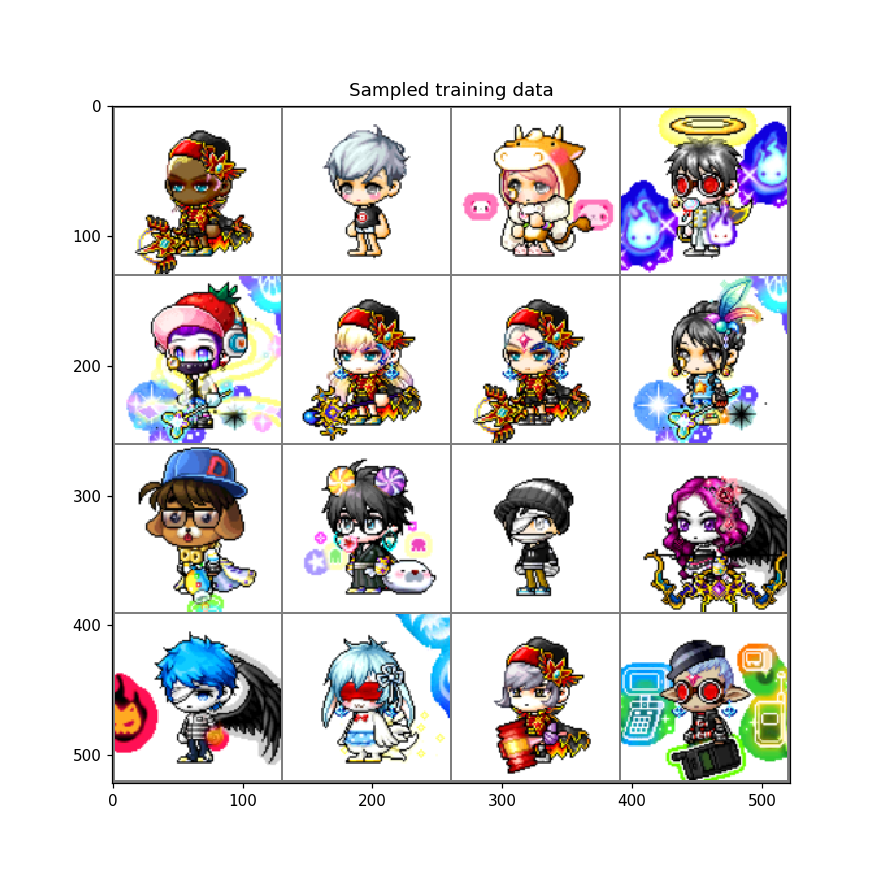

In [8]:
transform = transforms.Compose([transforms.Resize((WIDTH, HEIGHT)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader = get_loaders("datasets/maplestory", transform, 16, num_workers=N_CPU)

images = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, nrow=4), "Sampled training data", figsize=(8, 8))

## Model

![VAE](images/VAE.png)

In [9]:
class Encoder(nn.Module):
    def __init__(self, nc, ndf, z_dim):
        super(Encoder, self).__init__()
        self.ndf = ndf
        self.conv1 = nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf)
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8, ndf*8, 4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf*8)
        self.fc1 = nn.Linear(ndf*8*4*4, z_dim) # mu
        self.fc2 = nn.Linear(ndf*8*4*4, z_dim) # logvar
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        x = F.relu(self.bn5(self.conv5(x)), inplace=True)
        x = x.view(-1, self.ndf*8*4*4)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        return mu, logvar

While encoding is pretty straightforward, decoding through upsampling can be tricky. In order to prevent checkerboard patterns in output images, we'll use `resize-convolution` upsampling method mentioned in [this article](https://distill.pub/2016/deconv-checkerboard/).

In [10]:
class ResizeConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, normalize=True):
        super(ResizeConv2d, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.pad = nn.ReplicationPad2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, bias=False)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.pad(x)
        x = self.conv(x)
        return x

In [11]:
class Decoder(nn.Module):
    def __init__(self, nc, ngf, z_dim):
        super(Decoder, self).__init__()
        self.ngf = ngf
        self.fc1 = nn.Linear(z_dim, ngf*8*2*4*4)
        self.resize_conv1 = ResizeConv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        self.resize_conv2 = ResizeConv2d(ngf*8, ngf*4, 3, 1)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        self.resize_conv3 = ResizeConv2d(ngf*4, ngf*2, 3, 1)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        self.resize_conv4 = ResizeConv2d(ngf*2, ngf, 3, 1)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.resize_conv5 = ResizeConv2d(ngf, 3, 3, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, self.ngf*8*2, 4, 4)
        x = F.leaky_relu(self.bn1(self.resize_conv1(x)), inplace=True)
        x = F.leaky_relu(self.bn2(self.resize_conv2(x)), inplace=True)
        x = F.leaky_relu(self.bn3(self.resize_conv3(x)), inplace=True)
        x = F.leaky_relu(self.bn4(self.resize_conv4(x)), inplace=True)
        x = F.sigmoid(self.resize_conv5(x))
        return x

Now, for the complete model.

In [12]:
class VAE(nn.Module):
    def __init__(self, nc, ndf, ngf, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(nc, ndf, z_dim)
        self.decoder = Decoder(nc, ngf, z_dim)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_ = self.decoder(z)
        return x_, mu, logvar

In [13]:
model = VAE(3, 64, 64, Z_DIM).to(device)
summary(model, input_size=(3, HEIGHT, WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 256, 16, 16]         524,288
       BatchNorm2d-6          [-1, 256, 16, 16]             512
            Conv2d-7            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
            Conv2d-9            [-1, 512, 4, 4]       4,194,304
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
           Linear-11                  [-1, 500]       4,096,500
           Linear-12                  [-1, 500]       4,096,500
          Encoder-13     [[-1, 500], [-1, 500]]               0
           Linear-14                [-1

## Training

In [14]:
def vae_loss(x, x_, mu, logvar):
    bce = F.binary_cross_entropy(x_, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

In [19]:
optimizer = optim.Adam(model.parameters())

In [20]:
def train(model, train_loader, log_freq):
    model.train()
    for i, x in enumerate(tqdm(train_loader, desc="iters.", leave=False)):
        x = x.to(device)
        optimizer.zero_grad()
        loss = vae_loss(x, *model(x))
        loss.backward()
        optimizer.step()
        if i % log_freq == 0:
            yield loss.item()

In [21]:
def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, x in enumerate(test_loader):
            x = x.to(device)
            x_, mu, logvar = model(x)
            test_loss += vae_loss(x, x_, mu, logvar)
            if i == 0:
                comparison = torch.cat([x, x_.view(BATCH_SIZE, 3, HEIGHT, WIDTH)])
                save_image(comparison.cpu(), f"results/maple-VAE/reconst_{epoch}.png", nrow=4)
    return test_loss

In [22]:
def sample(model, epoch):
    with torch.no_grad():
        z = torch.randn(64, Z_DIM).to(device)
        x_ = model.decoder(z).cpu()
        save_image(x_.view(64, 3, HEIGHT, WIDTH), f"results/sample_{epoch}.png")

### Single-batch test

In [27]:
x = iter(train_loader).next()
for i in tqdm(range(10000)):
    x = x.to(device)
    optimizer.zero_grad()
    x_, mu, logvar = model(x)
    loss = vae_loss(x, x_, mu, logvar)
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        comparison = torch.cat([x, x_.view(BATCH_SIZE, 3, HEIGHT, WIDTH)])
        save_image(comparison.cpu(), f"results/maple-VAE/single-batch/reconst_{i}.png", nrow=4)

### Coffee break

<IPython.core.display.Javascript object>


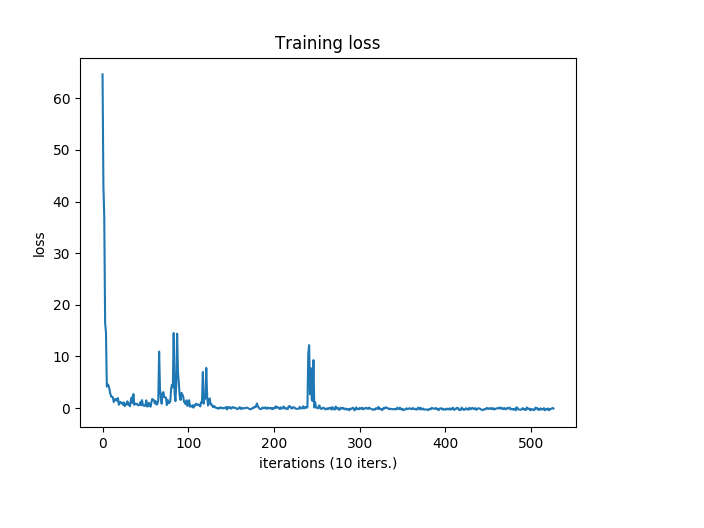

====> Test set loss: 151.75535583496094


====> Test set loss: -80.97859191894531


Process Process-24:
Process Process-21:
Process Process-23:
Process Process-22:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jin/anaconda3/envs/research/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jin/anaconda3/envs/research/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/jin/anaconda3/envs/research/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/jin/anaconda3/envs/research/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jin/anaconda3/envs/research/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jin/anaconda3/envs/research/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    s

KeyboardInterrupt: 

In [20]:
log_freq = 10
export_path = "models/maple_vae.pt"
    
fig, ax = plt.subplots()
train_losses = []

def update_fig(data, title, xlabel, ylabel):
    ax.clear()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data)
    plt.show()
    fig.canvas.draw()

for epoch in tqdm(range(N_EPOCHS), desc="epochs"):
    for train_loss in train(model, train_loader, log_freq):
        train_losses.append(train_loss)
        update_fig(train_losses, 
                   "Training loss", 
                   f"iterations ({log_freq} iters.)", 
                   "loss")
        
    test_loss = test(model, test_loader, epoch)
    print(f"====> Test set loss: {test_loss}")
    sample(model, epoch)

torch.save(model, export_path)

In [22]:
torch.cuda.empty_cache()